In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



In [2]:
# Fetch historical data for a stock (e.g., Apple)
stock_symbol = "AAPL"
data = yf.download(stock_symbol, start="2010-01-01", end="2024-01-01")

# Show the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2010-01-04  6.447413  7.643214  7.660714  7.585000  7.622500  493729600
2010-01-05  6.458560  7.656429  7.699643  7.616071  7.664286  601904800
2010-01-06  6.355828  7.534643  7.686786  7.526786  7.656429  552160000
2010-01-07  6.344077  7.520714  7.571429  7.466071  7.562500  477131200
2010-01-08  6.386255  7.570714  7.571429  7.466429  7.510714  447610800


In [3]:
# Use only the 'Close' prices for prediction
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])  # Previous 'seq_length' time steps as input
        y.append(data[i, 0])  # The actual value at time 'i' as the target
    return np.array(x), np.array(y)

seq_length = 60  # Use 60 previous days to predict the next day's price
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [4]:
# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units and return sequences for stacking more LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Adding a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with a single neuron (stock price prediction)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2024-12-02 22:47:29.300828: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/marcelofelix/.cache/pypoetry/virtualenvs/tech-challenge-4-deep-learning-nesDZ3vB-py3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0081 - val_loss: 0.0020
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.6317e-04 - val_loss: 0.0018
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.6074e-04 - val_loss: 0.0012
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.6532e-04 - val_loss: 0.0011
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 4.5063e-04 - val_loss: 0.0011
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.9255e-04 - val_loss: 9.3037e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.3551e-04 - val_loss: 0.0043
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.5865e-04 - val_loss: 0.0035
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 3.8643e-04 - val_loss: 0.0010
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.3192e-04 - val_loss: 8.3560e-04


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Squared Error: 30.56385912111316
Root Mean Squared Error: 5.528459018669955


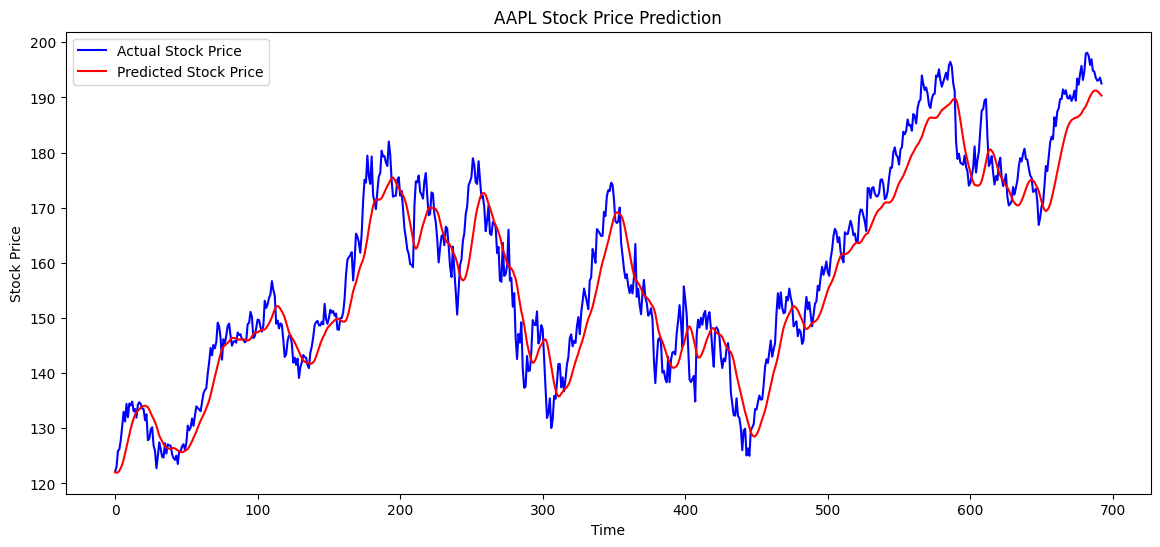

In [7]:
# Predicting the stock prices on the test data
predicted_prices = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back to original scale
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE and RMSE
mse = mean_squared_error(y_test_actual, predicted_prices)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [9]:
# Save the model to a file
model.save('stock_prediction_lstm_model.keras')